In [1]:
import random
import numpy as np
import pandas as pd
import copy
import time
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt

In [2]:
class Network(object):

    def __init__(self, sizes):
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]
        
        # helper variables
        self.bias_nitem = sum(sizes[1:])
        self.weight_nitem = sum([self.weights[i].size for i in range(self.num_layers-2)])

    def feedforward(self, a):
        for b, w in zip(self.biases, self.weights):
            a = self.sigmoid(np.dot(w,a)+b)
        return a

    def sigmoid(self, z):
        return 1.0/(1.0+np.exp(-z))

    def score(self, X, y):
        total_score=0
        for i in range(X.shape[0]):
            predicted = self.feedforward(X[i].reshape(-1,1))
            actual = y[i].reshape(-1,1)
            total_score += np.sum(np.power(predicted-actual,2))  # mean-squared error
        return total_score/X.shape[0]

    def accuracy(self, X, y):
        accuracy = 0
        for i in range(X.shape[0]):
            output = (self.feedforward(X[i].reshape(-1,1))).reshape(-1)
            condition = True
            for j in range(len(output)):
                output[j] = round(output[j])
            for j in range(len(output)):
                if(output[j]!=y[i][j]):
                    condition = False
                    break
            if condition:
                accuracy += 1
        return accuracy / X.shape[0] * 100

    def __str__(self):
        s = "\nBias:\n\n" + str(self.biases)
        s += "\nWeights:\n\n" + str(self.weights)
        s += "\n\n"
        return s

In [3]:
class NNGeneticAlgo:

    def __init__(self, n_pops, net_size, mutation_rate, crossover_rate, X, y, X_test, y_test):
        self.n_pops = n_pops
        self.net_size = net_size
        self.nets = [Network(self.net_size) for i in range(self.n_pops)]
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.X = X[:]
        self.y = y[:]
        self.X_test = X_test[:]
        self.y_test = y_test[:]
        self.accuracy_train = []
        self.accuracy_test = []
        self.best = Network(self.net_size)
            
    def get_random_point(self, type):
        nn = self.nets[0]
        layer_index, point_index = random.randint(0, nn.num_layers-2), 0
        if type == 'weight':
            row = random.randint(0,nn.weights[layer_index].shape[0]-1)
            col = random.randint(0,nn.weights[layer_index].shape[1]-1)
            point_index = (row, col)
        elif type == 'bias':
            point_index = random.randint(0,nn.biases[layer_index].size-1)
        return (layer_index, point_index)

    def get_all_scores(self,Xc,yc):
        return [net.score(Xc,yc) for net in self.nets]

    def get_all_accuracy(self,Xc,yc):
        return [net.accuracy(Xc,yc) for net in self.nets]

    def crossover(self):
        for i in range(self.n_pops):
            if random.uniform(0,1) < self.crossover_rate:
                father = random.randint(0,self.n_pops-1)
                mother = random.randint(0,self.n_pops-1)
                # make a copy of father 'genetic' weights & biases information
                nn_1 = copy.deepcopy(self.nets[father])
                nn_2 = copy.deepcopy(self.nets[mother])
                # cross-over bias
                k_1 = random.randint(int(0.5*self.nets[0].bias_nitem),self.nets[0].bias_nitem)
                for _ in range(k_1):
                    # get some random points
                    layer, point = self.get_random_point('bias')
                    # replace genetic (bias) with mother's value
                    nn_1.biases[layer][point] = self.nets[mother].biases[layer][point]
                    nn_2.biases[layer][point] = self.nets[father].biases[layer][point]

                # cross-over weight
                k_2 = random.randint(int(0.5*self.nets[0].weight_nitem),self.nets[0].weight_nitem)
                for _ in range(k_2):
                    # get some random points
                    layer, point = self.get_random_point('weight')
                    # replace genetic (weight) with mother's value
                    nn_1.weights[layer][point] = self.nets[mother].weights[layer][point]
                    nn_2.weights[layer][point] = self.nets[father].weights[layer][point]
                self.nets.append(copy.deepcopy(nn_1))
                self.nets.append(copy.deepcopy(nn_2))
        
    def mutation(self):
        for i in range(self.n_pops):
            if random.uniform(0,1) < self.mutation_rate:
                origin = random.randint(0,self.n_pops-1)
                nn = copy.deepcopy(self.nets[origin])

                # mutate bias
                k_1 = random.randint(int(0.5*self.nets[0].bias_nitem),self.nets[0].bias_nitem)
                for _ in range(k_1):
                    # get some random points
                    layer, point = self.get_random_point('bias')
                    # add some random value between -0.5 and 0.5
                    nn.biases[layer][point] += random.uniform(-0.5, 0.5)

                # mutate weight
                k_2 = random.randint(int(0.5*self.nets[0].weight_nitem),self.nets[0].weight_nitem)
                for _ in range(k_2):
                    # get some random points
                    layer, point = self.get_random_point('weight')
                    # add some random value between -0.5 and 0.5
                    nn.weights[layer][point[0], point[1]] += random.uniform(-0.5, 0.5)
                self.nets.append(copy.deepcopy(nn))
        
    def selection(self,Xc,yc):
        nets_new=[]
        for i in range(self.n_pops):
            k_1 = random.randint(0,len(self.nets)-1)
            k_2 = random.randint(0,len(self.nets)-1)
            if(self.nets[k_1].score(Xc,yc)<self.nets[k_2].score(Xc,yc)):
                nets_new.append(self.nets[k_1])
            else:
                nets_new.append(self.nets[k_2])
        self.nets = copy.deepcopy(nets_new)
    
    def sort_nets(self,Xc,yc):
        # calculate score for each population of neural-net
        score_list = list(zip(self.nets, self.get_all_scores(Xc,yc)))

        # sort the network using its score
        score_list.sort(key=lambda x: x[1])

        # exclude score as it is not needed anymore
        score_list = [obj[0] for obj in score_list]
        self.nets = copy.deepcopy(score_list)
        if(self.best.accuracy(self.X,self.y)<self.nets[0].accuracy(self.X,self.y)):
            self.best = copy.deepcopy(self.nets[0])

    def evolve(self):
        start_time = time.time()
        for t in range(25):
            self.accuracy_train.append(self.best.accuracy(self.X,self.y))
            self.accuracy_test.append(self.best.accuracy(self.X_test,self.y_test))
            for i in range(20):
                j1=i*40
                j2=(1+i)*40
                Xc=self.X[j1:j2,:]
                yc=self.y[j1:j2,:]
                for k in range(25): 
                    self.crossover()
                    self.mutation()
                    self.selection(Xc,yc)
                    self.sort_nets(Xc,yc)
                print("Current iteration : {}, batch : {}".format(t+1,i+1))
                print("Time taken by far : %.1f seconds" % (time.time() - start_time))
                print("Current top member's network score: %.5f " % self.best.score(self.X,self.y))
                print("Current top member's network accuracy: %.2f%%\n" % self.best.accuracy(self.X,self.y))

In [4]:
df = pd.read_csv("../Data/data_(8-8).csv")

In [5]:
X = df.iloc[:800, :8].values
y = df.iloc[:800, 8:16].values
sc = StandardScaler()
X = sc.fit_transform(X)
X_test = df.iloc[800:1000, :8].values
y_test = df.iloc[800:1000, 8:16].values
sc = StandardScaler()
X_test = sc.fit_transform(X_test)

In [6]:
N_POPS = 100
NET_SIZE = [8,8,8]
MUTATION_RATE = 0.1
CROSSOVER_RATE = 0.8
nnga = NNGeneticAlgo(N_POPS, NET_SIZE, MUTATION_RATE, CROSSOVER_RATE, X, y, X_test, y_test)
nnga.evolve()

Current iteration : 1, batch : 1
Time taken by far : 12.2 seconds
Current top member's network score: 1.26197 
Current top member's network accuracy: 24.00%

Current iteration : 1, batch : 2
Time taken by far : 23.9 seconds
Current top member's network score: 0.95990 
Current top member's network accuracy: 32.62%

Current iteration : 1, batch : 3
Time taken by far : 35.4 seconds
Current top member's network score: 0.93791 
Current top member's network accuracy: 38.75%

Current iteration : 1, batch : 4
Time taken by far : 46.3 seconds
Current top member's network score: 0.82600 
Current top member's network accuracy: 44.00%

Current iteration : 1, batch : 5
Time taken by far : 58.5 seconds
Current top member's network score: 0.75714 
Current top member's network accuracy: 51.88%

Current iteration : 1, batch : 6
Time taken by far : 71.8 seconds
Current top member's network score: 0.70703 
Current top member's network accuracy: 56.75%

Current iteration : 1, batch : 7
Time taken by far :

Current iteration : 3, batch : 13
Time taken by far : 598.5 seconds
Current top member's network score: 0.32463 
Current top member's network accuracy: 85.88%

Current iteration : 3, batch : 14
Time taken by far : 609.2 seconds
Current top member's network score: 0.32463 
Current top member's network accuracy: 85.88%

Current iteration : 3, batch : 15
Time taken by far : 622.6 seconds
Current top member's network score: 0.32463 
Current top member's network accuracy: 85.88%

Current iteration : 3, batch : 16
Time taken by far : 634.4 seconds
Current top member's network score: 0.32463 
Current top member's network accuracy: 85.88%

Current iteration : 3, batch : 17
Time taken by far : 645.7 seconds
Current top member's network score: 0.32463 
Current top member's network accuracy: 85.88%

Current iteration : 3, batch : 18
Time taken by far : 657.0 seconds
Current top member's network score: 0.32463 
Current top member's network accuracy: 85.88%

Current iteration : 3, batch : 19
Time t

Current iteration : 6, batch : 5
Time taken by far : 1270.1 seconds
Current top member's network score: 0.30229 
Current top member's network accuracy: 87.12%

Current iteration : 6, batch : 6
Time taken by far : 1290.4 seconds
Current top member's network score: 0.30229 
Current top member's network accuracy: 87.12%

Current iteration : 6, batch : 7
Time taken by far : 1310.4 seconds
Current top member's network score: 0.30229 
Current top member's network accuracy: 87.12%

Current iteration : 6, batch : 8
Time taken by far : 1329.0 seconds
Current top member's network score: 0.30229 
Current top member's network accuracy: 87.12%

Current iteration : 6, batch : 9
Time taken by far : 1347.9 seconds
Current top member's network score: 0.30229 
Current top member's network accuracy: 87.12%

Current iteration : 6, batch : 10
Time taken by far : 1368.4 seconds
Current top member's network score: 0.30229 
Current top member's network accuracy: 87.12%

Current iteration : 6, batch : 11
Time 

Current iteration : 8, batch : 17
Time taken by far : 2335.6 seconds
Current top member's network score: 0.28430 
Current top member's network accuracy: 87.75%

Current iteration : 8, batch : 18
Time taken by far : 2357.2 seconds
Current top member's network score: 0.26414 
Current top member's network accuracy: 88.25%

Current iteration : 8, batch : 19
Time taken by far : 2379.3 seconds
Current top member's network score: 0.26414 
Current top member's network accuracy: 88.25%

Current iteration : 8, batch : 20
Time taken by far : 2400.9 seconds
Current top member's network score: 0.26414 
Current top member's network accuracy: 88.25%

Current iteration : 9, batch : 1
Time taken by far : 2422.5 seconds
Current top member's network score: 0.26414 
Current top member's network accuracy: 88.25%

Current iteration : 9, batch : 2
Time taken by far : 2444.5 seconds
Current top member's network score: 0.26414 
Current top member's network accuracy: 88.25%

Current iteration : 9, batch : 3
Tim

Current iteration : 11, batch : 8
Time taken by far : 3450.2 seconds
Current top member's network score: 0.26766 
Current top member's network accuracy: 89.00%

Current iteration : 11, batch : 9
Time taken by far : 3469.8 seconds
Current top member's network score: 0.26766 
Current top member's network accuracy: 89.00%

Current iteration : 11, batch : 10
Time taken by far : 3489.5 seconds
Current top member's network score: 0.26766 
Current top member's network accuracy: 89.00%

Current iteration : 11, batch : 11
Time taken by far : 3508.9 seconds
Current top member's network score: 0.26766 
Current top member's network accuracy: 89.00%

Current iteration : 11, batch : 12
Time taken by far : 3528.1 seconds
Current top member's network score: 0.26766 
Current top member's network accuracy: 89.00%

Current iteration : 11, batch : 13
Time taken by far : 3547.2 seconds
Current top member's network score: 0.26766 
Current top member's network accuracy: 89.00%

Current iteration : 11, batch 

Current iteration : 13, batch : 19
Time taken by far : 4443.3 seconds
Current top member's network score: 0.25533 
Current top member's network accuracy: 89.50%

Current iteration : 13, batch : 20
Time taken by far : 4465.9 seconds
Current top member's network score: 0.25533 
Current top member's network accuracy: 89.50%

Current iteration : 14, batch : 1
Time taken by far : 4489.0 seconds
Current top member's network score: 0.25533 
Current top member's network accuracy: 89.50%

Current iteration : 14, batch : 2
Time taken by far : 4508.8 seconds
Current top member's network score: 0.25533 
Current top member's network accuracy: 89.50%

Current iteration : 14, batch : 3
Time taken by far : 4528.5 seconds
Current top member's network score: 0.25533 
Current top member's network accuracy: 89.50%

Current iteration : 14, batch : 4
Time taken by far : 4550.2 seconds
Current top member's network score: 0.25533 
Current top member's network accuracy: 89.50%

Current iteration : 14, batch : 

Current iteration : 16, batch : 10
Time taken by far : 5447.5 seconds
Current top member's network score: 0.25533 
Current top member's network accuracy: 89.50%

Current iteration : 16, batch : 11
Time taken by far : 5466.6 seconds
Current top member's network score: 0.25533 
Current top member's network accuracy: 89.50%

Current iteration : 16, batch : 12
Time taken by far : 5486.1 seconds
Current top member's network score: 0.25533 
Current top member's network accuracy: 89.50%

Current iteration : 16, batch : 13
Time taken by far : 5505.4 seconds
Current top member's network score: 0.25533 
Current top member's network accuracy: 89.50%

Current iteration : 16, batch : 14
Time taken by far : 5524.4 seconds
Current top member's network score: 0.25533 
Current top member's network accuracy: 89.50%

Current iteration : 16, batch : 15
Time taken by far : 5543.9 seconds
Current top member's network score: 0.25533 
Current top member's network accuracy: 89.50%

Current iteration : 16, batc

Current iteration : 19, batch : 1
Time taken by far : 6431.2 seconds
Current top member's network score: 0.22408 
Current top member's network accuracy: 90.88%

Current iteration : 19, batch : 2
Time taken by far : 6450.2 seconds
Current top member's network score: 0.22408 
Current top member's network accuracy: 90.88%

Current iteration : 19, batch : 3
Time taken by far : 6469.7 seconds
Current top member's network score: 0.22408 
Current top member's network accuracy: 90.88%

Current iteration : 19, batch : 4
Time taken by far : 6488.7 seconds
Current top member's network score: 0.22408 
Current top member's network accuracy: 90.88%

Current iteration : 19, batch : 5
Time taken by far : 6507.5 seconds
Current top member's network score: 0.22408 
Current top member's network accuracy: 90.88%

Current iteration : 19, batch : 6
Time taken by far : 6527.1 seconds
Current top member's network score: 0.22408 
Current top member's network accuracy: 90.88%

Current iteration : 19, batch : 7


Current iteration : 21, batch : 12
Time taken by far : 7413.6 seconds
Current top member's network score: 0.24013 
Current top member's network accuracy: 91.00%

Current iteration : 21, batch : 13
Time taken by far : 7432.8 seconds
Current top member's network score: 0.24013 
Current top member's network accuracy: 91.00%

Current iteration : 21, batch : 14
Time taken by far : 7452.2 seconds
Current top member's network score: 0.24013 
Current top member's network accuracy: 91.00%

Current iteration : 21, batch : 15
Time taken by far : 7471.3 seconds
Current top member's network score: 0.24013 
Current top member's network accuracy: 91.00%

Current iteration : 21, batch : 16
Time taken by far : 7490.5 seconds
Current top member's network score: 0.24013 
Current top member's network accuracy: 91.00%

Current iteration : 21, batch : 17
Time taken by far : 7509.8 seconds
Current top member's network score: 0.24013 
Current top member's network accuracy: 91.00%

Current iteration : 21, batc

Current iteration : 24, batch : 3
Time taken by far : 8396.4 seconds
Current top member's network score: 0.24013 
Current top member's network accuracy: 91.00%

Current iteration : 24, batch : 4
Time taken by far : 8415.6 seconds
Current top member's network score: 0.24013 
Current top member's network accuracy: 91.00%

Current iteration : 24, batch : 5
Time taken by far : 8435.1 seconds
Current top member's network score: 0.24013 
Current top member's network accuracy: 91.00%

Current iteration : 24, batch : 6
Time taken by far : 8454.6 seconds
Current top member's network score: 0.24013 
Current top member's network accuracy: 91.00%

Current iteration : 24, batch : 7
Time taken by far : 8474.0 seconds
Current top member's network score: 0.24013 
Current top member's network accuracy: 91.00%

Current iteration : 24, batch : 8
Time taken by far : 8494.1 seconds
Current top member's network score: 0.24013 
Current top member's network accuracy: 91.00%

Current iteration : 24, batch : 9


In [12]:
nnga.best.accuracy(X,y)

91.0

In [13]:
nnga.best.accuracy(X_test,y_test)

86.0

In [7]:
accuracy_train = np.array(nnga.accuracy_train)
accuracy_test = np.array(nnga.accuracy_test)

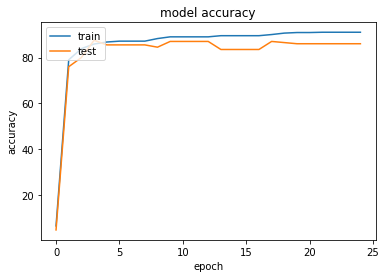

In [8]:
plt.plot(accuracy_train)
plt.plot(accuracy_test )
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [9]:
#Dependencies
import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout
# Neural network
model = Sequential()
model.add(Dense(8, input_dim=8, activation="sigmoid"))
model.add(Dense(8, activation="sigmoid"))

In [10]:
for i in range(len(model.layers)):
    model.layers[i].set_weights([nnga.best.weights[i].T,nnga.best.biases[i].reshape(-1)])

In [11]:
from keras.models import load_model
model.save('model_NN_GA_8_8_8.h5')  # creates a HDF5 file 'my_model.h5'
del model